In [1]:
# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import os
import sys
import random

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# Custom utilities
sys.path.append('../')
from src.utils import load_config, split_into_sentences, flatten_list, load_and_clean_data
from src import stats_analysis as sa
from src.data_cleaning import add_average_data


[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
config = load_config('../config.yaml')
data = load_and_clean_data(config)
data = add_average_data(data)
print(data.temperature_enc.value_counts())
print(data.has_paraphrase.value_counts())

Data contains at the begining : 22953
Filtering data with more than 20 sentences and less than 5 sentences. 20947 samples left
Filtering data with phone numbers. 20908 samples left
Filtering data with addresses. 20540 samples left
Filtering data with mail addresses. 20540 samples left
Filtering data with list. 20022 samples left
Filtering data with short paraphrase. 19048 samples left
Filtering data with paraphrase at the end. 18848 samples left
temperature_enc
medium_temperature    6673
low_temperature       6543
high_temperature      5632
Name: count, dtype: int64
has_paraphrase
0    10184
1     8664
Name: count, dtype: int64


In [8]:
from src.semantic_density import narrative_speed_score

data['narrative_speed_score_test'] = data['sentence_sim_vectors'].apply(lambda x: narrative_speed_score(x)) 

In [47]:
density_features = ['narrative_speed_score',
                    'reduction_score_PCA_explained_variance',
                    #'reduction_score_PCA_prop_of_components',
                    'cluster_density_score_HDBSCAN',
                    'cluster_reverse_silhouette_score_HDBSCAN',
                    'cluster_density_score_MeanShift',
                    'cluster_reverse_silhouette_score_MeanShift',
                    #'regression_coef_density_score_Lasso',
                    'regression_error_score_Lasso',
                    #'reduction_score_Lasso'
                    ]
Structural_density = [
                        'cluster_density_score_HDBSCAN', 
                        'cluster_reverse_silhouette_score_HDBSCAN',
                        'cluster_density_score_MeanShift', 
                        'cluster_reverse_silhouette_score_MeanShift',
                        'reduction_score_PCA_explained_variance', 
                        'reduction_score_PCA_prop_of_components',]

Semantic_contribution = ['regression_coef_density_score_Lasso',
    'regression_error_score_Lasso',
    'reduction_score_Lasso',
    ]


data_dense = data[density_features]

print(density_features)

['narrative_speed_score', 'reduction_score_PCA_explained_variance', 'cluster_density_score_HDBSCAN', 'cluster_reverse_silhouette_score_HDBSCAN', 'cluster_density_score_MeanShift', 'cluster_reverse_silhouette_score_MeanShift', 'regression_error_score_Lasso']


## Correlation analysis

In [1]:
from scipy.cluster.hierarchy import linkage, leaves_list

corr_matrix = data_dense.corr(method='pearson')

linkage_matrix = linkage(corr_matrix, method='average')

# Step 3: Reorder the correlation matrix
# Get the order of the leaves
order = leaves_list(linkage_matrix)

# Reorder the correlation matrix according to the hierarchical clustering
reordered_corr_matrix = corr_matrix.iloc[order, order]

# Reorder the correlation matrix according to the hierarchical clustering
reordered_corr_matrix = corr_matrix.iloc[order, order]

# Step 4: Visualize the reordered correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_corr_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 15})
plt.xticks(rotation=35, ha='right', fontsize=16)  # Change x-axis label font size here
plt.yticks(fontsize=16)
plt.title('Reordered Correlation Matrix with Clustered Features')
plt.show()

NameError: name 'data_dense' is not defined

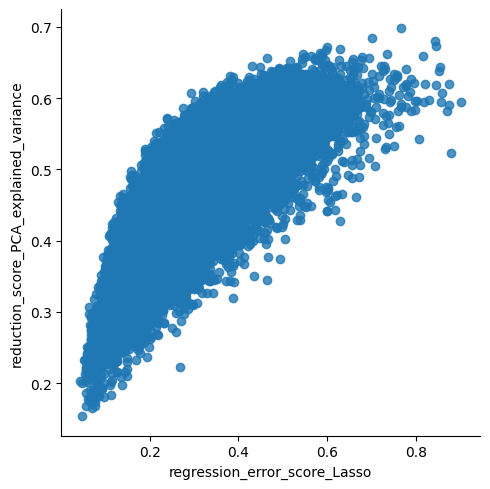

In [51]:
sns.lmplot(data_dense, x='regression_error_score_Lasso', y='reduction_score_PCA_explained_variance', fit_reg=False)

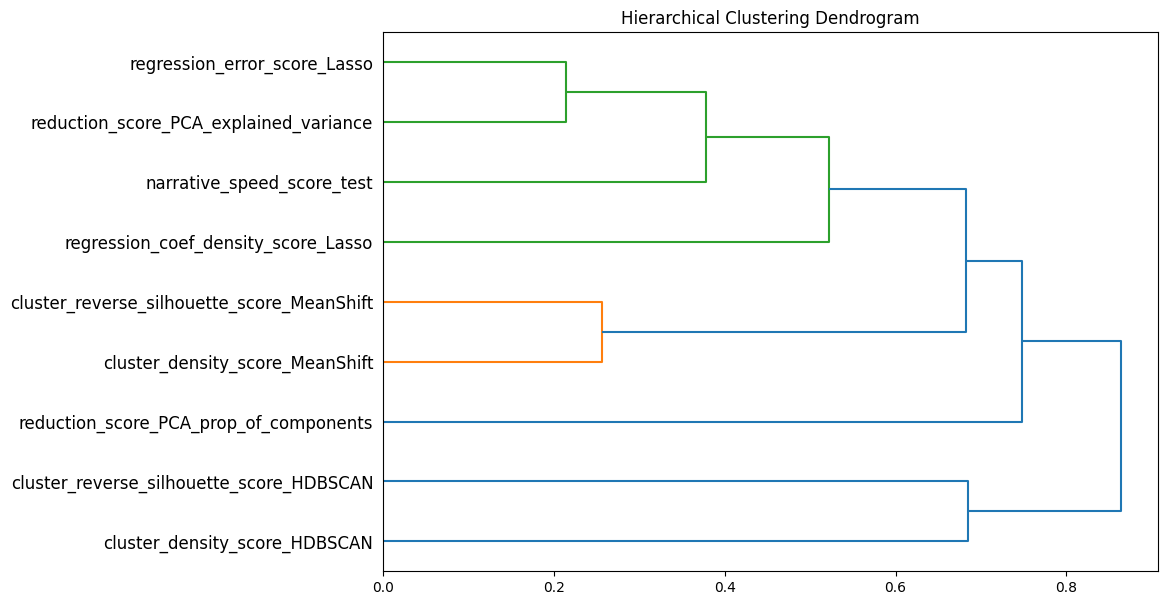

{4: ['narrative_speed_score_test',
  'reduction_score_PCA_explained_variance',
  'regression_coef_density_score_Lasso',
  'regression_error_score_Lasso'],
 5: ['reduction_score_PCA_prop_of_components'],
 1: ['cluster_density_score_HDBSCAN'],
 2: ['cluster_reverse_silhouette_score_HDBSCAN'],
 3: ['cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift']}

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

def group_features_by_clustering(data, method='average', threshold=1.5, cluster_coef = "kendall",num_clusters=None):
    # Calculate the correlation matrix
    corr_matrix = data.corr(method=cluster_coef).abs()
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - corr_matrix
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(squareform(distance_matrix), method=method)
    
    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=corr_matrix.columns, leaf_rotation=0, orientation='right')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()
    
    # Create clusters using the threshold
    if num_clusters:
        clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    else:
        clusters = fcluster(linkage_matrix, threshold, criterion='distance')
    
    # Group features by clusters
    grouped_features = {}
    for idx, cluster in enumerate(clusters):
        grouped_features.setdefault(cluster, []).append(corr_matrix.columns[idx])
    
    return grouped_features

# Example usage
grouped_features = group_features_by_clustering(data_dense, method="average", threshold=0.6, cluster_coef="spearman",num_clusters=None)

grouped_features

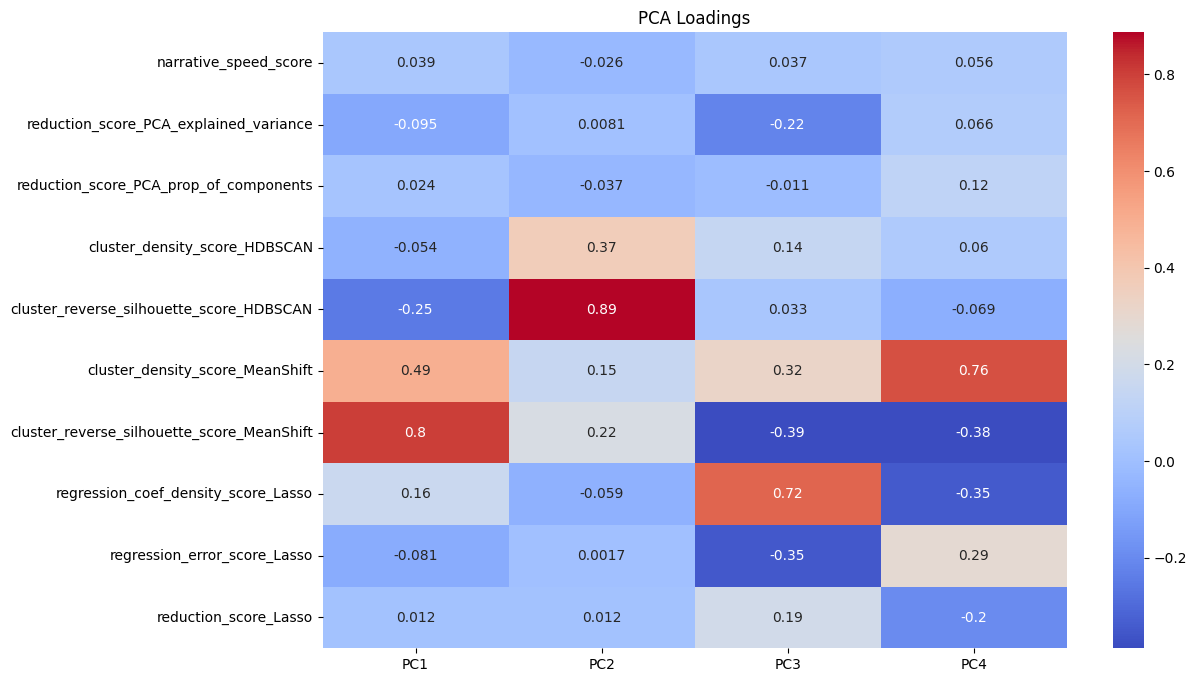

{'PC1': ['cluster_reverse_silhouette_score_HDBSCAN',
  'cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift'],
 'PC2': ['cluster_density_score_HDBSCAN',
  'cluster_reverse_silhouette_score_HDBSCAN',
  'cluster_reverse_silhouette_score_MeanShift'],
 'PC3': ['reduction_score_PCA_explained_variance',
  'cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift',
  'regression_coef_density_score_Lasso',
  'regression_error_score_Lasso'],
 'PC4': ['cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift',
  'regression_coef_density_score_Lasso',
  'regression_error_score_Lasso']}

In [57]:
def group_features_by_pca(data, n_components=2, loading_threshold=0.4):
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(data)
    
    # Get loadings (coefficients) for each feature
    loadings = pd.DataFrame(pca.components_.T, 
                            columns=[f'PC{i+1}' for i in range(n_components)], 
                            index=data.columns)
    
    # Group features by loadings on each component
    grouped_features = {}
    for component in loadings.columns:
        strong_loadings = loadings.index[abs(loadings[component]) > loading_threshold].tolist()
        grouped_features[component] = strong_loadings
    
    # Plot the loadings for visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm')
    plt.title('PCA Loadings')
    plt.show()
    
    return grouped_features, loadings, pca

# Example usage
grouped_features, loadings, pca_model = group_features_by_pca(data_dense, n_components=4, loading_threshold=0.2)

grouped_features

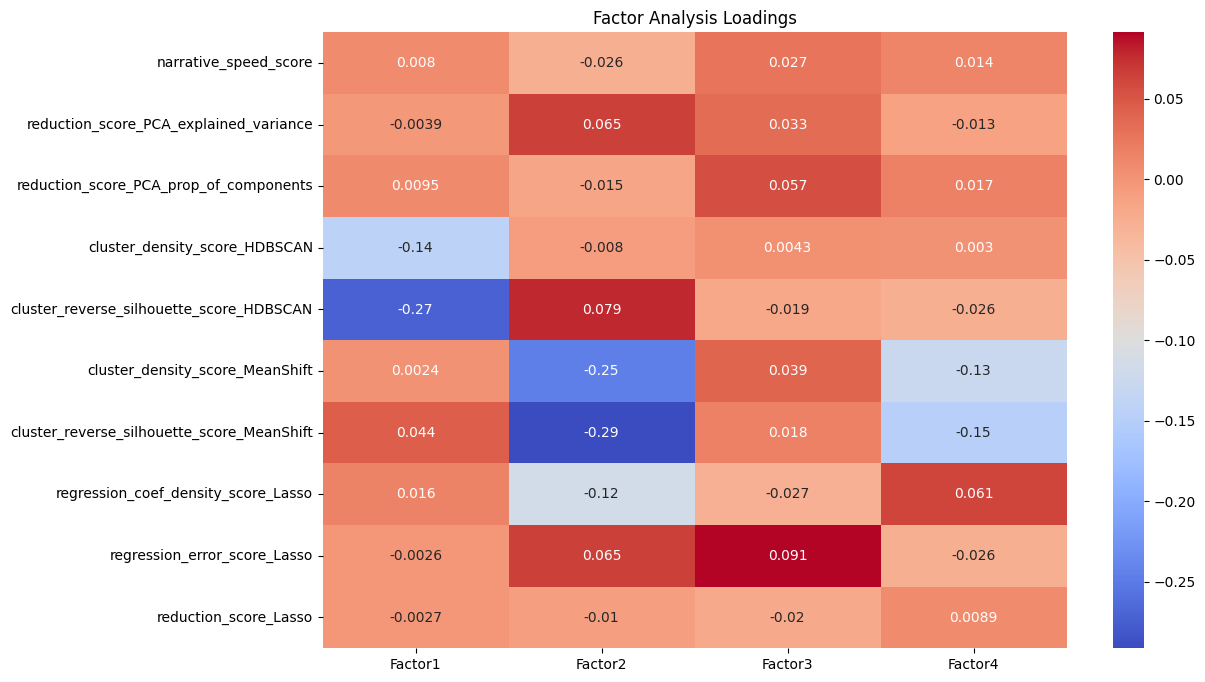

In [48]:
from sklearn.decomposition import FactorAnalysis

def group_features_by_factor_analysis(data, n_components=2, loading_threshold=0.4):
    # Perform Factor Analysis
    fa = FactorAnalysis(n_components=n_components)
    fa.fit(data)
    
    # Get loadings (coefficients) for each feature
    loadings = pd.DataFrame(fa.components_.T, 
                            columns=[f'Factor{i+1}' for i in range(n_components)], 
                            index=data.columns)
    
    # Group features by loadings on each factor
    grouped_features = {}
    for factor in loadings.columns:
        strong_loadings = loadings.index[abs(loadings[factor]) > loading_threshold].tolist()
        grouped_features[factor] = strong_loadings
    
    # Plot the loadings for visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm')
    plt.title('Factor Analysis Loadings')
    plt.show()
    
    return grouped_features, loadings, fa

# Example usage
grouped_features_fa, loadings_fa, fa_model = group_features_by_factor_analysis(data_dense, n_components=4, loading_threshold=0.4)

grouped_features_fa


In [49]:
grouped_features_fa

{'Factor1': [], 'Factor2': [], 'Factor3': [], 'Factor4': []}

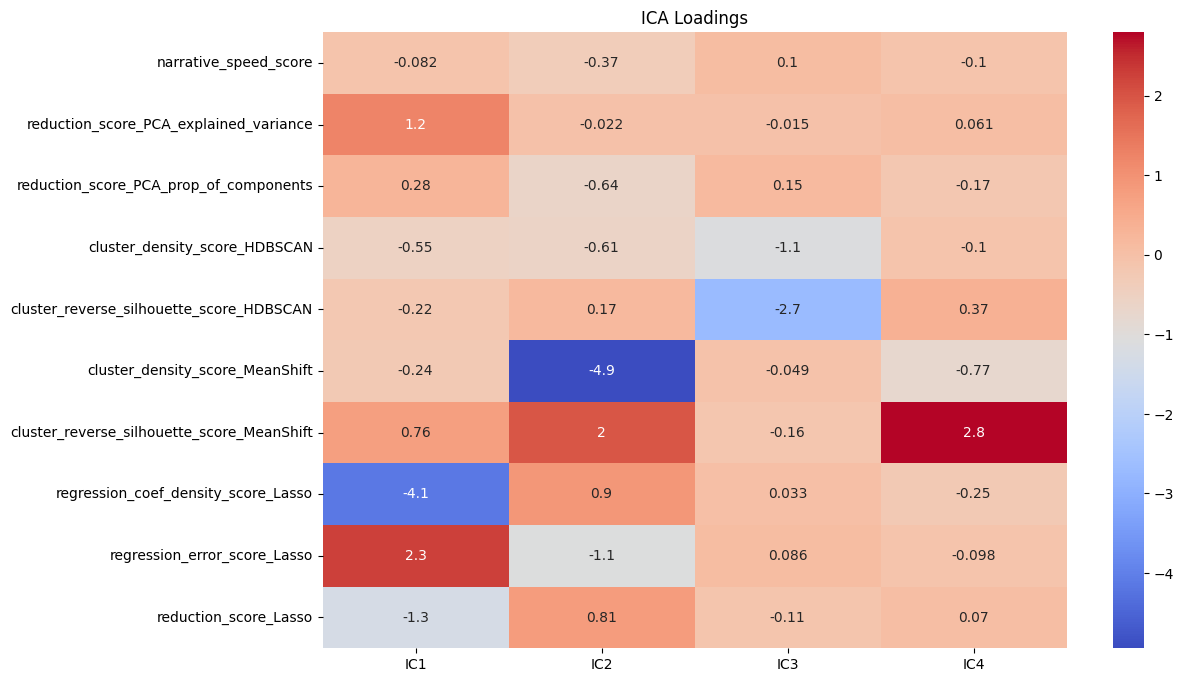

{'IC1': ['reduction_score_PCA_explained_variance',
  'cluster_density_score_HDBSCAN',
  'cluster_reverse_silhouette_score_MeanShift',
  'regression_coef_density_score_Lasso',
  'regression_error_score_Lasso',
  'reduction_score_Lasso'],
 'IC2': ['reduction_score_PCA_prop_of_components',
  'cluster_density_score_HDBSCAN',
  'cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift',
  'regression_coef_density_score_Lasso',
  'regression_error_score_Lasso',
  'reduction_score_Lasso'],
 'IC3': ['cluster_density_score_HDBSCAN',
  'cluster_reverse_silhouette_score_HDBSCAN'],
 'IC4': ['cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift']}

In [47]:
from sklearn.decomposition import FastICA

def group_features_by_ica(data, n_components=2, loading_threshold=0.4):
    # Perform ICA
    ica = FastICA(n_components=n_components)
    ica.fit(data)
    
    # Get loadings (coefficients) for each feature
    loadings = pd.DataFrame(ica.components_.T, 
                            columns=[f'IC{i+1}' for i in range(n_components)], 
                            index=data.columns)
    
    # Group features by loadings on each independent component
    grouped_features = {}
    for component in loadings.columns:
        strong_loadings = loadings.index[abs(loadings[component]) > loading_threshold].tolist()
        grouped_features[component] = strong_loadings
    
    # Plot the loadings for visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm')
    plt.title('ICA Loadings')
    plt.show()
    
    return grouped_features, loadings, ica

# Example usage
grouped_features_ica, loadings_ica, ica_model = group_features_by_ica(data_dense, n_components=4, loading_threshold=0.5)

grouped_features_ica

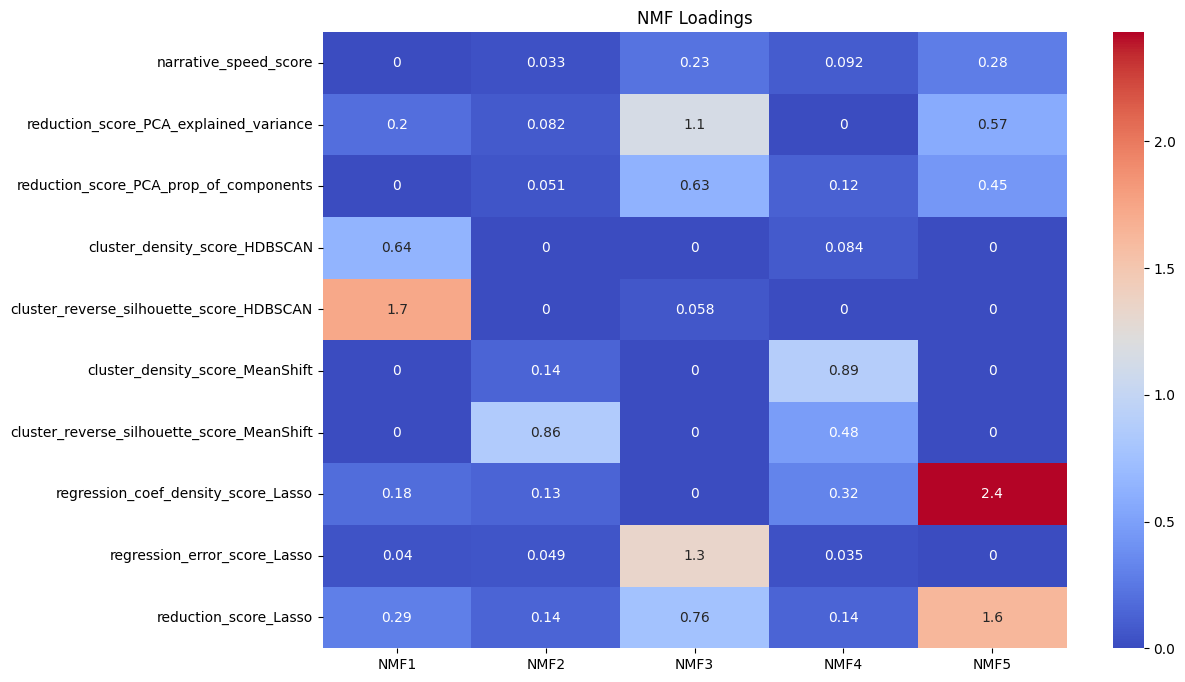

{'NMF1': ['cluster_density_score_HDBSCAN',
  'cluster_reverse_silhouette_score_HDBSCAN'],
 'NMF2': ['cluster_reverse_silhouette_score_MeanShift'],
 'NMF3': ['reduction_score_PCA_explained_variance',
  'reduction_score_PCA_prop_of_components',
  'regression_error_score_Lasso',
  'reduction_score_Lasso'],
 'NMF4': ['cluster_density_score_MeanShift',
  'cluster_reverse_silhouette_score_MeanShift'],
 'NMF5': ['reduction_score_PCA_explained_variance',
  'reduction_score_PCA_prop_of_components',
  'regression_coef_density_score_Lasso',
  'reduction_score_Lasso']}

In [42]:
from sklearn.decomposition import NMF

def group_features_by_nmf(data, n_components=2, loading_threshold=0.4):
    # Perform NMF
    nmf = NMF(n_components=n_components, init='random', random_state=0)
    nmf.fit(data)
    
    # Get loadings (coefficients) for each feature
    loadings = pd.DataFrame(nmf.components_.T, 
                            columns=[f'NMF{i+1}' for i in range(n_components)], 
                            index=data.columns)
    
    # Group features by loadings on each NMF component
    grouped_features = {}
    for component in loadings.columns:
        strong_loadings = loadings.index[abs(loadings[component]) > loading_threshold].tolist()
        grouped_features[component] = strong_loadings
    
    # Plot the loadings for visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm')
    plt.title('NMF Loadings')
    plt.show()
    
    return grouped_features, loadings, nmf

# Example usage
grouped_features_nmf, loadings_nmf, nmf_model = group_features_by_nmf(data_dense, n_components=5, loading_threshold=0.4)

grouped_features_nmf

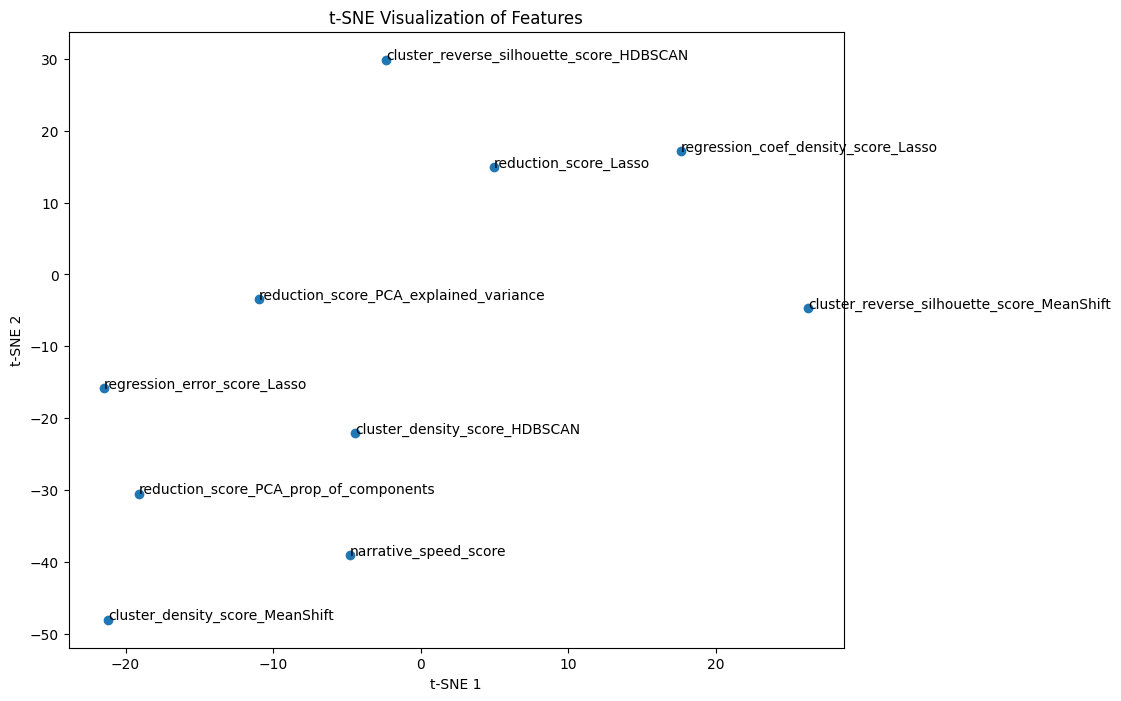

In [45]:
from sklearn.manifold import TSNE

def visualize_features_by_tsne(data, perplexity=5, n_components=2):
    # Perform t-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=0)
    tsne_results = tsne.fit_transform(data.T)  # Transpose to get features
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    
    for i, feature in enumerate(data.columns):
        plt.annotate(feature, (tsne_results[i, 0], tsne_results[i, 1]))
    
    plt.title('t-SNE Visualization of Features')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Example usage
visualize_features_by_tsne(data_dense)